# Homework 10

### Principles of Urban Informatics

#### Completed by #JKtours

# TIME SERIES ANALYSIS



# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [9]:
__author__ = 'JKtours'
import pylab as pl
import pandas as pd
import os
import json
import statsmodels.api as sm
import collections 

%pylab inline


Populating the interactive namespace from numpy and matplotlib


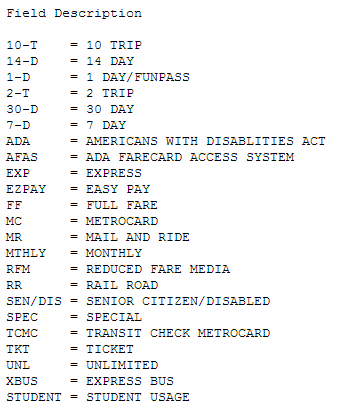

In [10]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 


In [66]:
 #get file from website, and puts into active directory

!curl -O https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy  

#os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA"))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  10.2M      0  0:00:01 --:--:--  0:00:01 48.6M


In [67]:
theData = np.load('MTA_Fare.npy')

In [68]:
theData.shape

(600, 23, 194)

## The data provides number of swipes for 600 stations by ticket type (with a total of 23 ticket types) across 194 weeks.


In [69]:
theData[0][0][0]     
# theData[0 -> first station][0 -> first ticket type: 10 TRIP][0 -> first week: 05/21/2010], 
# there were 56961 swipes

56961

Remove missing values (which were input as -1)

In [19]:
theDataClean = theData.astype(np.float)

In [20]:
np.place(theDataClean, theDataClean == -1, np.nan)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

We want to sum all ticket types across all stations by week. i.e. sum the first two dimensions for each week.

In [21]:
len(np.nansum(theDataClean,axis=1))

600

In [22]:
np.nansum(theDataClean,axis=1)[599]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [23]:
dates = pd.date_range(start="05/21/2010", freq='W',periods=194)
dates

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


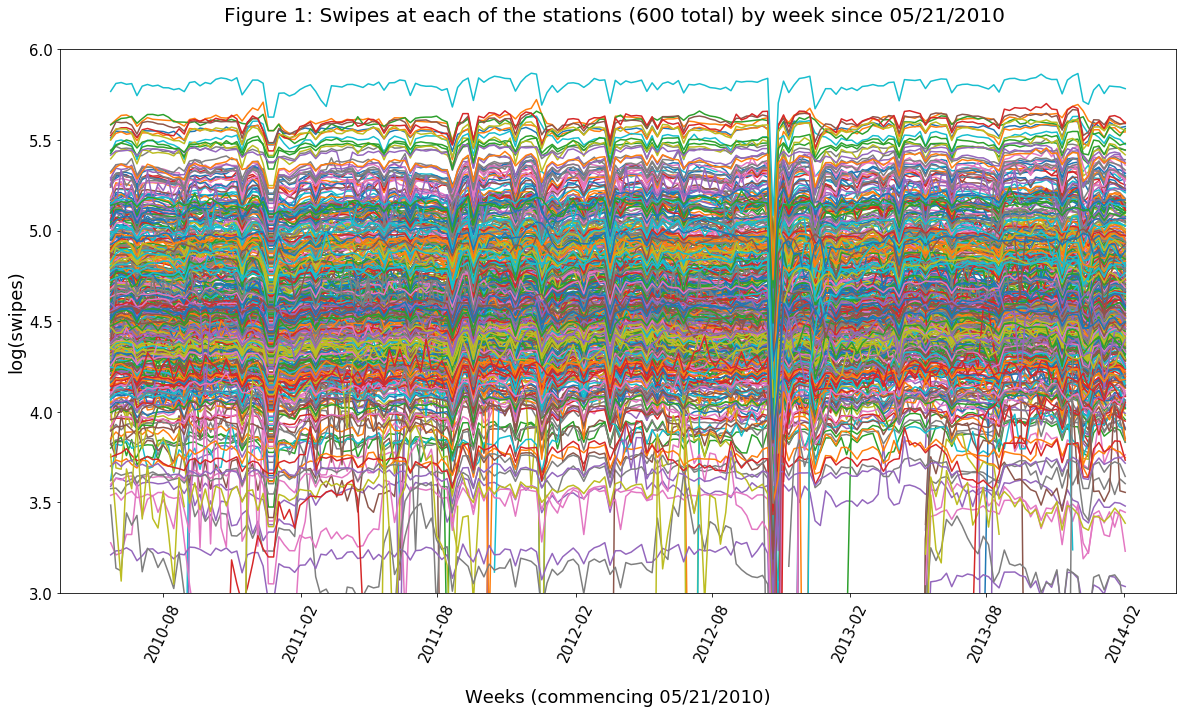

In [27]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

for i in range(len(np.nansum(theDataClean,axis=1))):
    ax.plot(dates, np.log10(np.nansum(theDataClean,axis=1)[i]))
    #ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 1: Swipes at each of the stations (600 total) by week since 05/21/2010 \n", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)
#ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("log(swipes)", fontsize=18)
ax.set_xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim(3,6)#0,100)1e4,1e6);
ax.set_xlim();

There appears to be a significant event around October 2012. Let's inspect the series with the highest volume.

In [29]:
highestVolID = np.argmax(np.nansum(np.nansum(theDataClean,axis=1),axis=1))

In [30]:
highestVolTix = np.nansum(theDataClean,axis=1)[highestVolID]

In [51]:
thresholds = [highestVolTix.mean() + 3 * highestVolTix.std(), 
              highestVolTix.mean() - 3 * highestVolTix.std()]
thresh = np.log10(highestVolTix * 0 + thresholds[1])

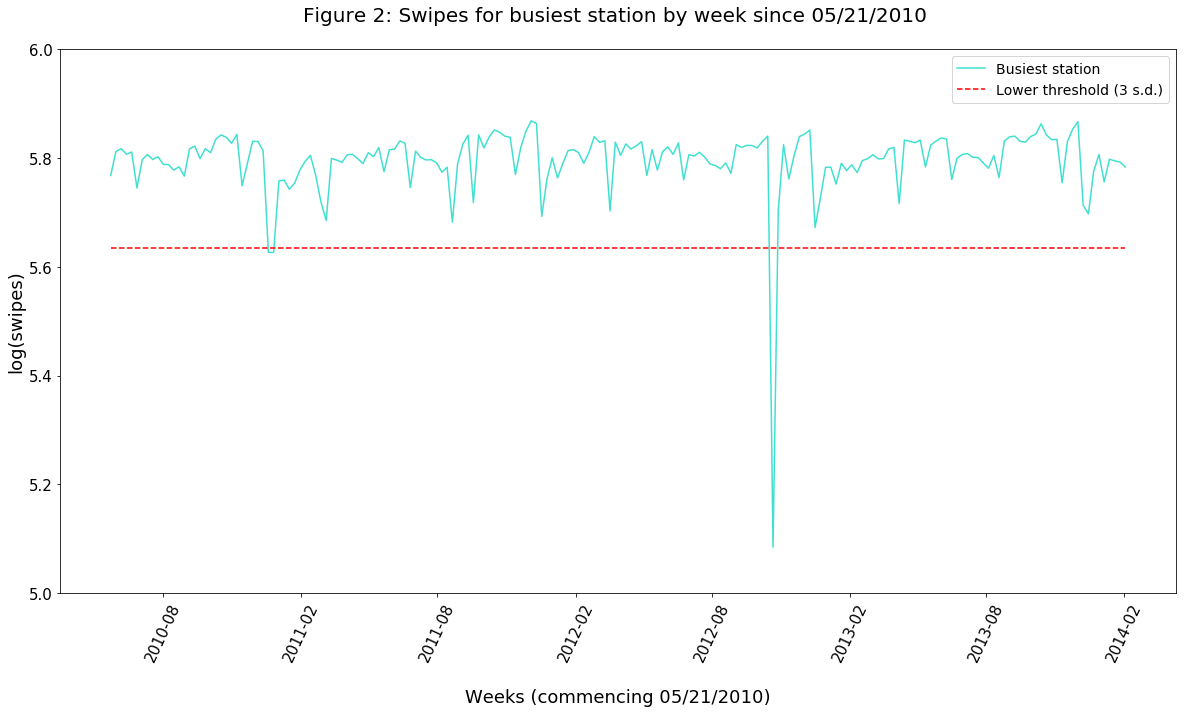

In [54]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)


ax.plot(dates, np.log10(np.nansum(theDataClean,axis=1)[highestVolID]), color='turquoise'
        , label = "Busiest station")
ax.plot(dates, thresh, 'r--', label = "Lower threshold (3 s.d.)")
    #ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 2: Swipes for busiest station by week since 05/21/2010 \n", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)
#ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("log(swipes)", fontsize=18)
ax.set_xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim(5,6)#0,100)1e4,1e6);
ax.set_xlim()
plt.legend(fontsize=14);

Plotting the busiest station confirms our suspicions there was a significant drop in swipes around October 2012. This appears to be a significant event. Let's identify which week it is.

In [71]:
WeekID = np.argmin(highestVolTix)
print("The week number of the specific event is {}".format(WeekID) + 
      " which corresponds to the week {}".format(dates[WeekID]))

The week number of the specific event is 126 which corresponds to the week 2012-10-21 00:00:00


In [66]:
dates[WeekID]
#list(dates)


Timestamp('2012-10-21 00:00:00', freq='W-SUN')

In [79]:
avgStationSwipesCount = np.nanmean(np.nansum(theDataClean,axis=1), axis = 0)

thresholds = [avgStationSwipesCount.mean() + 3 * avgStationSwipesCount.std(), 
              avgStationSwipesCount.mean() - 3 * avgStationSwipesCount.std()]
thresholds


[64555.385227061131, 34715.781010052269]

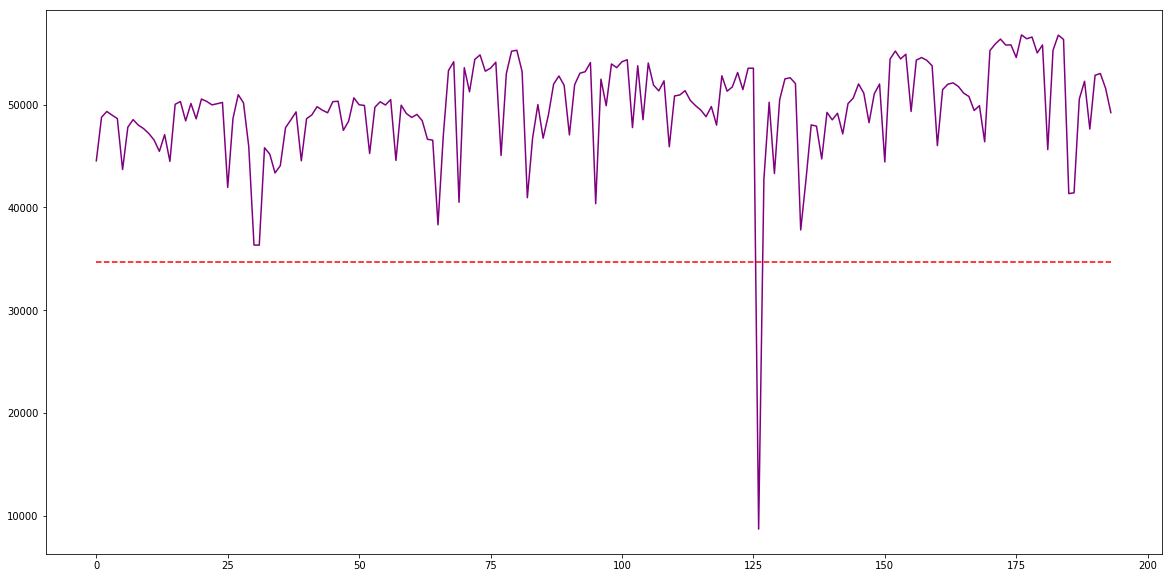

In [80]:
plt.figure(figsize=(20,10))
plot(avgStationSwipesCount, color='purple')

thresh = avgStationSwipesCount * 0 + thresholds[1]
plot(thresh, 'r--');


In [82]:
WeekID = np.argmin(avgStationSwipesCount)
WeekID

126

In [83]:
dates[WeekID]
#list(dates)

Timestamp('2012-10-21 00:00:00', freq='W-SUN')

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


In [137]:
np.nansum(theDataClean,axis=0).shape

(23L, 194L)

In [165]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

### Plot of swipes by ride type

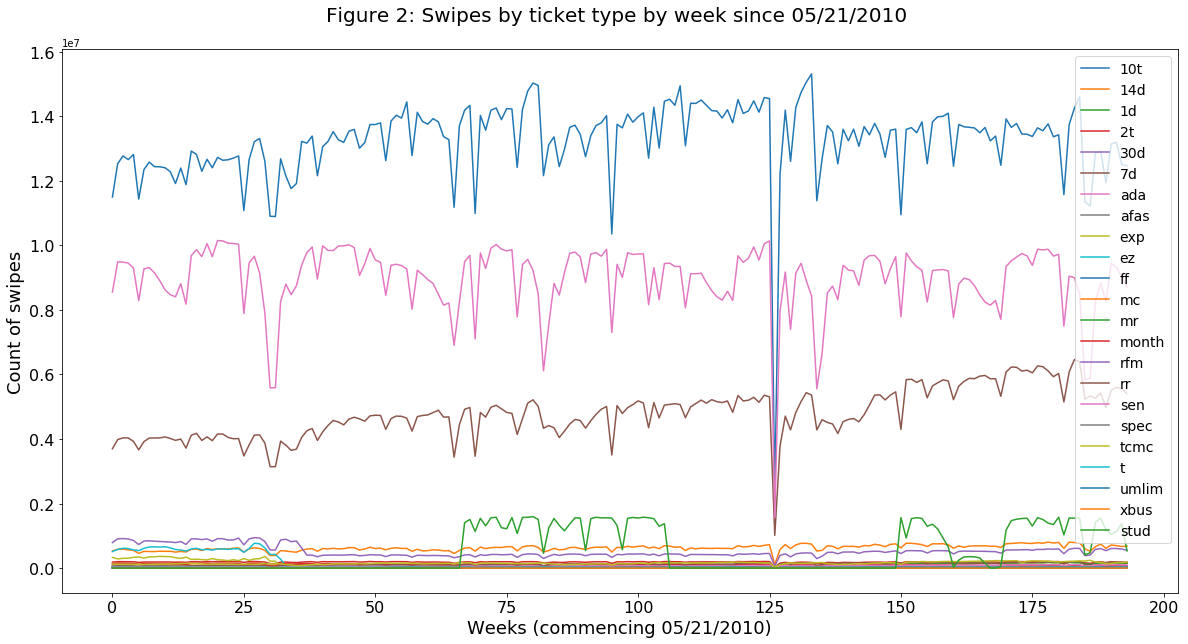

In [168]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

for i in range(len(np.nansum(theDataClean,axis=0))):
    plot(np.nansum(theDataClean,axis=0)[i], label = ridetype[i] )
    
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 2: Swipes by ticket type by week since 05/21/2010 \n", fontsize=20)
ax.set_ylabel("Count of swipes", fontsize=18)
ax.set_xlabel("Weeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim()#3,60,100)1e4,1e6);
ax.set_xlim();#0,100)
plt.legend(fontsize=14);
    

In [138]:
firstTenWeeksRidershipTotal, lastTenWeeksRidershipTotal

(5444706598.0, 5479513331.0)

We want to test if ridership is stationary across each of the ticket types. We will use the Augmented Dickey–Fuller test for unit root to test if the riderships are stationary.

**Stating the Null Hypothesis:** Testing ridership over time, the null hypothesis is that the the ridership has a unit root and is non-stationary

$H_0$: The series has a unit root and is non-stationary

$H_a$: The series has no unit root. The series is stationary

$\alpha=0.05$

In [239]:
sigLevel = 0.05 #alpha

In [86]:
np.nansum(np.nansum(theDataClean,axis=0)[0][-10])

14604028.0

In [143]:
np.nansum(theDataClean,axis=0)[0:10][:].shape

(10L, 194L)

In [213]:
RidershipDifferences = arange(len(np.nansum(theDataClean,axis=0))) * 0 #set-up empty array to populate with ridership ratios
RidershipDifferences = RidershipDifferences.astype(np.float16)
pValueResult = arange(len(np.nansum(theDataClean,axis=0))) * 0 #set-up empty array to pValue results for stationarity
pValueResult = RidershipDifferences.astype(np.float16)

# Calculate TOTAL rider for first 10 weeks and last 10 weeks
firstTenWeeksRidershipTotal = np.nansum(np.nansum(theDataClean,axis=0)[:,0:10])
lastTenWeeksRidershipTotal = np.nansum(np.nansum(theDataClean,axis=0)[:,-10:])

# Set up pandas dataframe to store percentage differences by ticket type, and p-value of statistical test
columns=['TicketType', 'RidershipPercentChange', 'pValueResult']
dfResults = pd.DataFrame(columns=columns)

for i in range(len(np.nansum(theDataClean,axis=0))):
    
    firstTenWeeksRidershipTicketRatio = np.nansum(np.nansum(theDataClean,axis=0)[i][0:10]) / firstTenWeeksRidershipTotal
    lastTenWeeksRidershipTicketRatio = np.nansum(np.nansum(theDataClean,axis=0)[i][-10:]) / lastTenWeeksRidershipTotal
    #print(firstTenWeeksRidershipTicketRatio, lastTenWeeksRidershipTicketRatio)

    ridershipDiff = format(lastTenWeeksRidershipTicketRatio - firstTenWeeksRidershipTicketRatio)
    RidershipDifferences[i] = ridershipDiff
    
    pVal = sm.tsa.adfuller(np.nansum(theDataClean,axis=0)[i])[1]  # Idenitifies p-value for AD-Fuller test
    pValueResult[i] = pVal

    dfResults.loc[i]= [ridetype[i] , ridershipDiff, pVal]

In [240]:
dfNonStatResults = dfResults[dfResults['pValueResult'] > sigLevel]
dfNonStatResults 

TicketType RidershipPercentChange  pValueResult
1         14d       0.00375146346251      0.222908
2          1d       0.00011514176431      0.232794
5          7d        0.0458635531056      0.525873
7        afas     -0.000384442153745      0.086881
9          ez       -0.0209821133335      0.118460
10         ff     -0.000310123097749      0.536185
11         mc      0.000756997384033      0.872198
12         mr       0.00482757408485      0.931244
13      month      -0.00213908669686      0.548666
14        rfm        -0.011140694143      0.231693
15         rr       0.00335908658227      0.760907
16        sen       0.00195656513239      0.738896
17       spec       0.00105418083787      0.072036
21       xbus      9.91049758343e-06      0.383860
22       stud        0.0358857585413      0.052313

In [241]:
for i in dfNonStatResults.index:
    print("Ridership of {}".format(dfNonStatResults['TicketType'][i]) + " is non-stationary, and observed change" + 
          " in ratio of usage between the first 10 and last 10 weeks is {}%"
          .format(round(float(dfNonStatResults['RidershipPercentChange'][i]),4)*100))

Ridership of 14d is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is 0.38%
Ridership of 1d is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is 0.01%
Ridership of 7d is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is 4.59%
Ridership of afas is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is -0.04%
Ridership of ez is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is -2.1%
Ridership of ff is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is -0.03%
Ridership of mc is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is 0.08%
Ridership of mr is non-stationary, and observed change in ratio of usage between the first 10 and last 10 weeks is 0.48%
Ridership of month is non-s


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (identify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [243]:
# Collapse the fare types dimension of the cube as we care about stations here
mtaSwipesAllStations = np.nansum(theDataClean, axis=1)

In [253]:
mtaSwipesAllStations_power = range(len(mtaSwipesAllStations))


C:\Users\Jonathan\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5,1,u'Power Spectrum for all 600 Subway stations in New York')

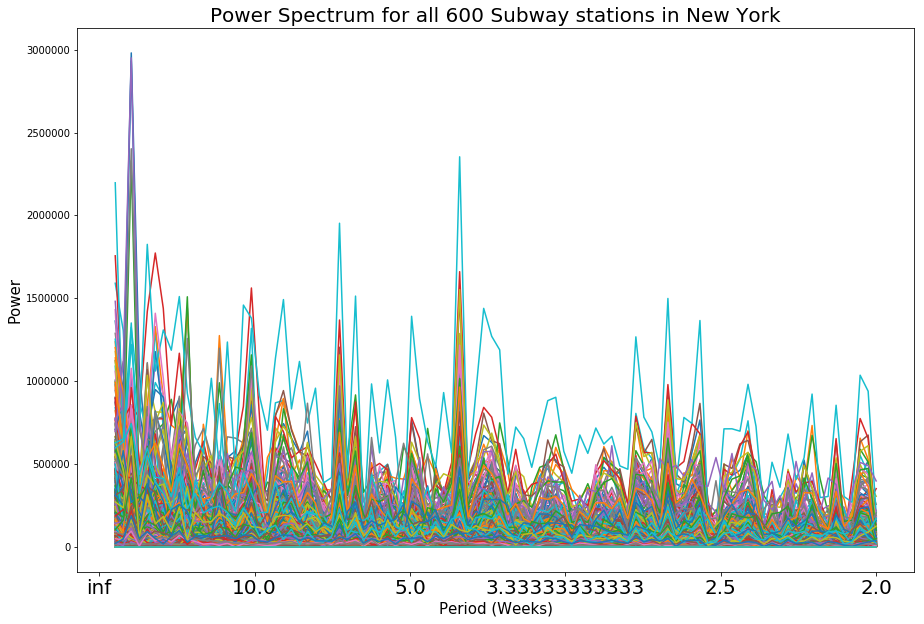

In [255]:


# Visually inspect all the stations plotting their power spectrum, excluding the first two elements on the X
# (Frequencies that correspond Infinity and the whole period: "Uninteresting")
# as explained in https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb

N = len(mtaSwipesAllStations[1])
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)


# Create a dictionary to store the frequency bin centers in cycles per week (X Axis)
# and the Fourier Transform value (Y) for eac of the stations

mtaSwipesAllStations_yearPeriodicity = {}

for i in range (len(mtaSwipesAllStations)):
    f = np.abs(np.fft.rfft(mtaSwipesAllStations[i]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    mtaSwipesAllStations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-')
    mtaSwipesAllStations_yearPeriodicity[i]=((f[4]))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (Weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

ax.set_title('Power Spectrum for all 600 Subway stations in New York', fontsize=20)

**Figure 2:** This plot is the power spectrun of the 600 stations. It is extremely busy, but helps giving us an idea of the largest spikes for centain frequncy bins. As we are looking into yearly periodicity we will focus on the initial positions of the array, but we see from this graph that there might be other interesting periodicities


In [256]:
# Explore the frequency bins

print ("Center of the bin 3: " + str(1 / ffreq [3]) + ' Weeks')
print ("Center of the bin 4: " + str(1 / ffreq [4]) + ' Weeks')
print ("Center of the bin 5: " + str(1 / ffreq [5]) + ' Weeks')

Center of the bin 3: 64.6666666667 Weeks
Center of the bin 4: 48.5 Weeks
Center of the bin 5: 38.8 Weeks


In [260]:
# The fourth position of the array (1 / 48.5 weeks) is the closest (year is aprox 52.1429 weks)
# Lets get the stations with the higher values for this bin
# Will use collections.counter, code snippet from
# http://stackoverflow.com/questions/11902665/top-values-from-dictionary

d = collections.Counter(mtaSwipesAllStations_yearPeriodicity)
most_yearly_periodic_stations = []

for k, v in d.most_common(4):
    most_yearly_periodic_stations.append(k)

print ("The most common stations with yearly period are: " + str (most_yearly_periodic_stations))

The most common stations with yearly period are: [0, 194, 150, 327]


C:\Users\Jonathan\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


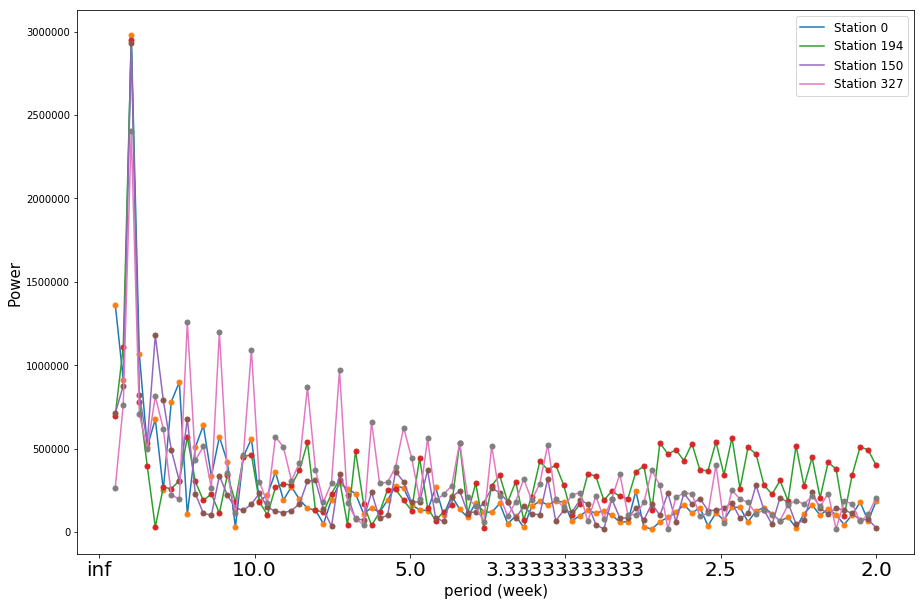

In [263]:
# Visualize the power spectrum only for those four stations (cleaner chart!)

N = len(mtaSwipesAllStations[1])
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
pl.xlabel("period (week)", fontsize=15)
pl.ylabel("Power", fontsize=15)


for i in range(len(most_yearly_periodic_stations)):
    f = np.abs(np.fft.rfft(mtaSwipesAllStations[most_yearly_periodic_stations[i]]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    mtaSwipesAllStations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-', label="Station " + str(most_yearly_periodic_stations[i]))
    ax.plot(ffreq[2:], (f[2:]), 'o', ms=5)
    mtaSwipesAllStations_yearPeriodicity[i]=((f[4]))

ax.legend(loc='best', fontsize=12)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20);


**Figure VII:** This plot presents the power spectrun of the 4 most periodic stations in New York.
Now that we have identified the most yearly periodic stations, we will attempt to find a cause for this periodicity. As we dont have any data that relates the station to a particular location, we will just look into the dates where these surges happen. For this we will plot only these stations swipes

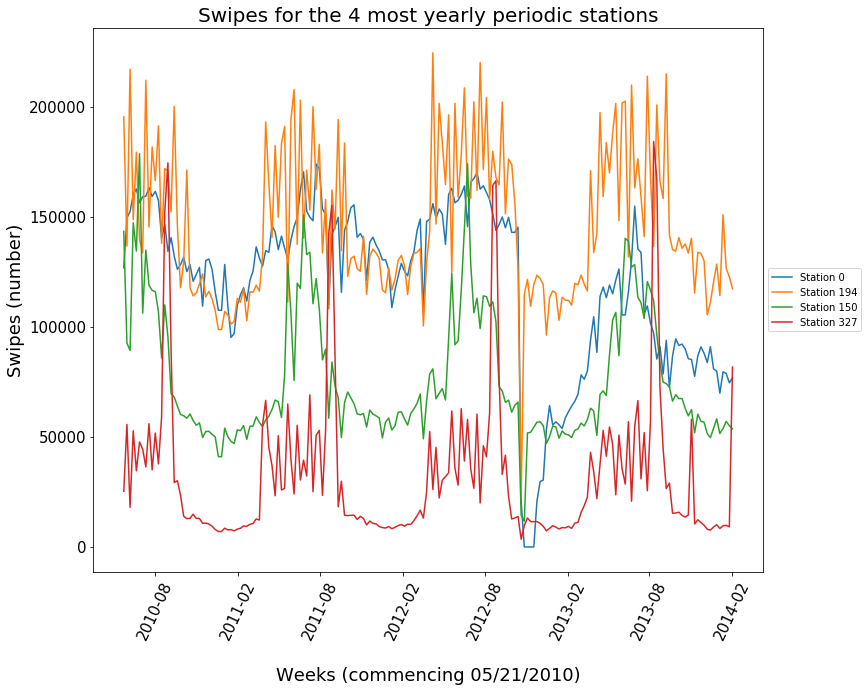

In [270]:
# Plotting the station swipes and dates to try to find possible events that explain the periodicity

fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
pl.xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
pl.ylabel("Swipes (number)", fontsize=18)
ax.legend(loc='best', fontsize=16)
pl.title("Swipes for the 4 most yearly periodic stations", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)

for i in range(len(most_yearly_periodic_stations)):
    ax.plot(dates, mtaSwipesAllStations[most_yearly_periodic_stations[i]], 
            '-', label="Station " + str(most_yearly_periodic_stations[i]))
    
# Shrink current axis by 20%
# So I can put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


**Figure VIII:** This plot presents the swipes per week for the top 4 most periodic stations in Manhattan
From the new visualization we can see that the stations 327, 194 and 150 display the most clear annual periodicity with quite regular periods of spikes between april and september (warmer months). This might be related to the fact that these stations are used to access open spaces that are mostly used with warm weather. Station 0 seems to also present periodicity related to the warmer months, but it appears to be less pronounced.
Station 327 has a very clear spike somewhere around september, this might relate to a concrete event. Will take a period of a single year and visualize these three stations with better visibility on the X axis

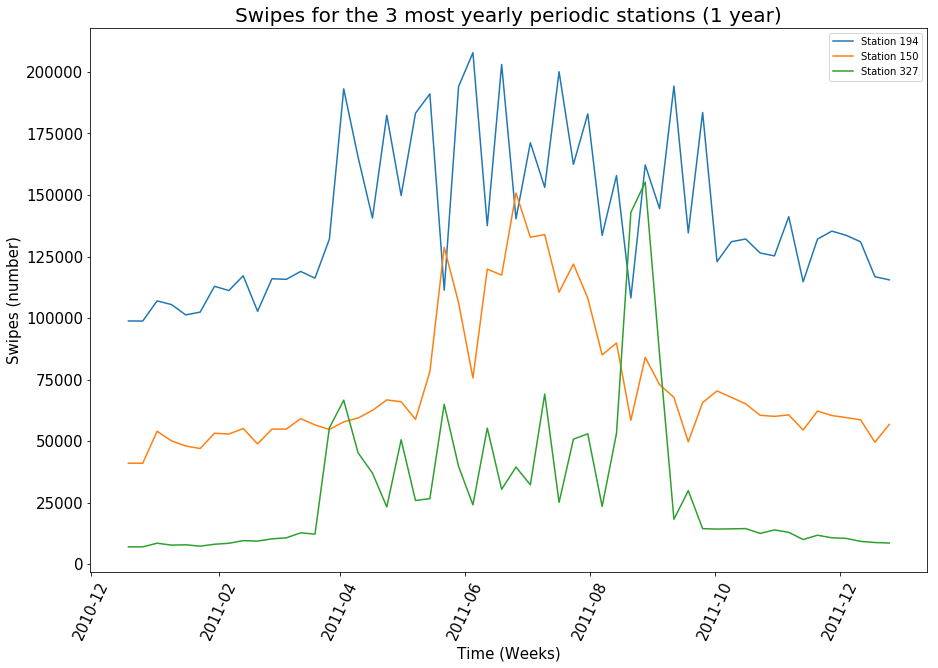

In [276]:
# Plotting the station swipes and dates to try to find possible events that explain the preiodicity

fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
pl.xlabel("Time (Weeks)", fontsize=15)
pl.ylabel("Swipes (number)", fontsize=15)
ax.legend(loc='best', fontsize=12)
pl.title("Swipes for the 3 most yearly periodic stations (1 year)", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)

# Remember the array with the top 5 periodic
# [0, 194, 150, 327, 32]

ax.plot(dates[30:84], mtaSwipesAllStations[most_yearly_periodic_stations[1]][30:84], 
            '-', label="Station " + str(most_yearly_periodic_stations[1]))
ax.plot(dates[30:84], mtaSwipesAllStations[most_yearly_periodic_stations[2]][30:84], 
            '-', label="Station " + str(most_yearly_periodic_stations[2]))
ax.plot(dates[30:84], mtaSwipesAllStations[most_yearly_periodic_stations[3]][30:84], 
            '-', label="Station " + str(most_yearly_periodic_stations[3]))
ax.legend(loc='best');

**Figure IX:** This plot presents the swipes per week for the top 3 most periodic stations in Manhattan for a period of 52 weeks


## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

In [2]:
#after reading the datacube you should see:
mtaRides.shape


(600, 23, 194)

ride types list

In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

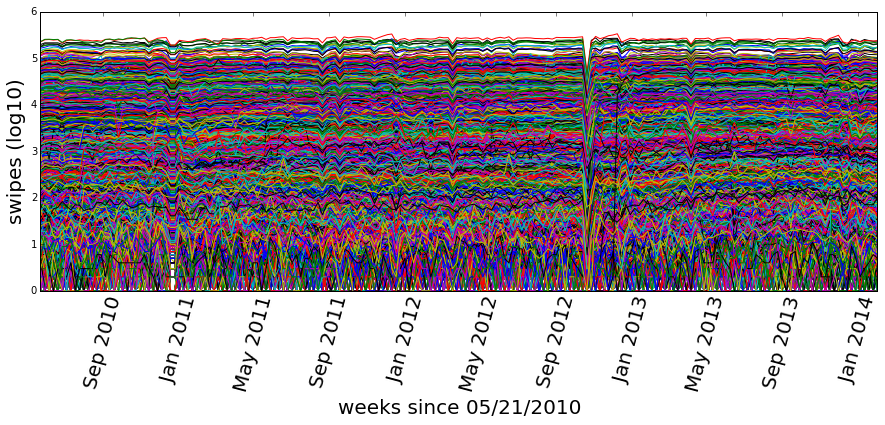

In [6]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRide.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtaRides, axis=1)
print (mta_allsum.shape)



(600, 23, 194)
(23, 194)
(600, 194)


## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

std: 153167.095823 
flux ratio beginning to end 1.53960256599
std: 33307.6081244 
flux ratio beginning to end 0.378670623705


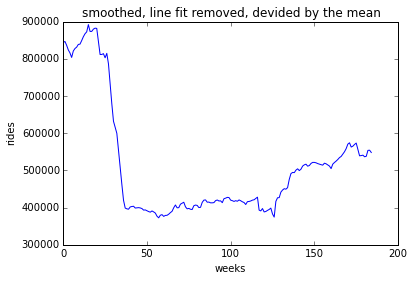

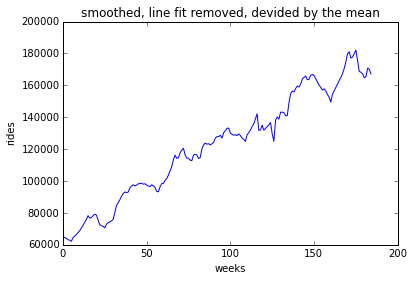

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

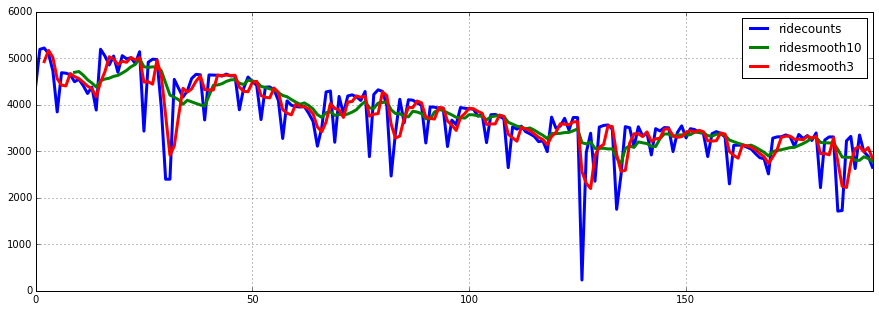

In [14]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

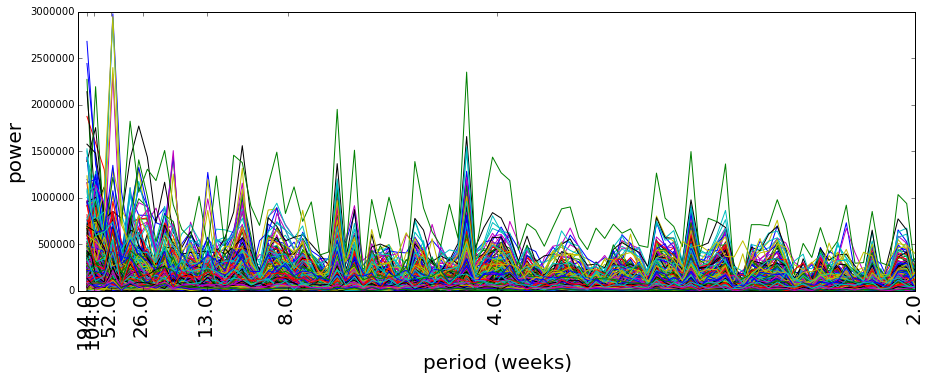

In [51]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 

...
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

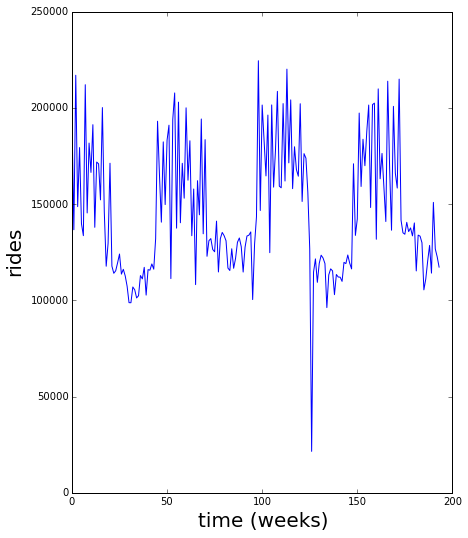

In [63]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space